# Import data

In [175]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib as plt

df = pd.read_csv("Walmart_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Data Exploration

## Individual Feature Exploration

### Stores

In [176]:
# r = df.groupby("Store").describe()
# r

### Date

### Weekly Sales

### Holiday Flag

<Axes: >

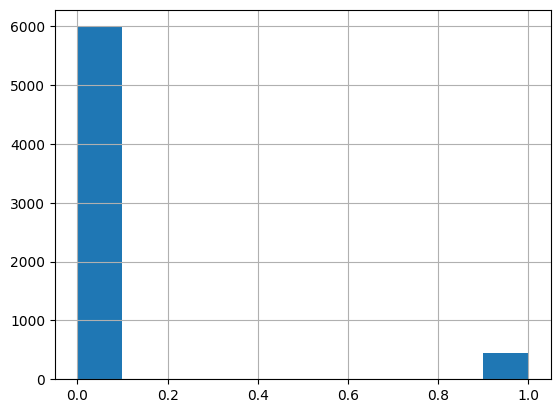

In [177]:
df['Holiday_Flag'].hist()

From this, we can analysze that their is very low percatnge of weeks that are holiday's and from this we can infer that non-holidays week's which are defined as 0 will have a smaller effect on sales vs the non-holidays weeks.

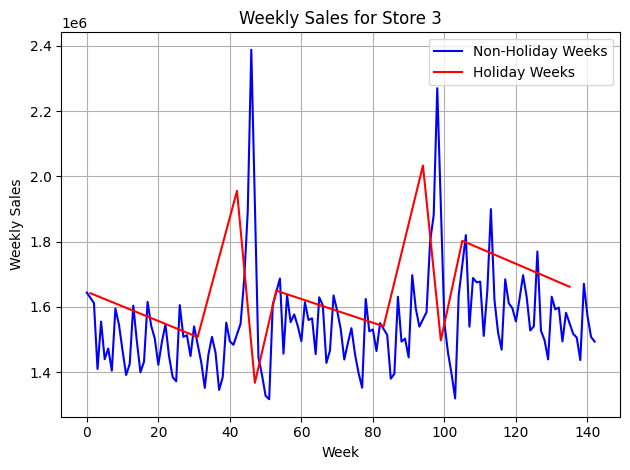

In [178]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_1.index, non_holiday_1['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_1.index, holiday_1['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 3')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()



The interaction between the sales data during non-holiday and holiday weeks highlights the impact of holidays on consumer behavior and sales activity for Store 1, providing valuable insights for strategic decision-making in retail management

### Tempature

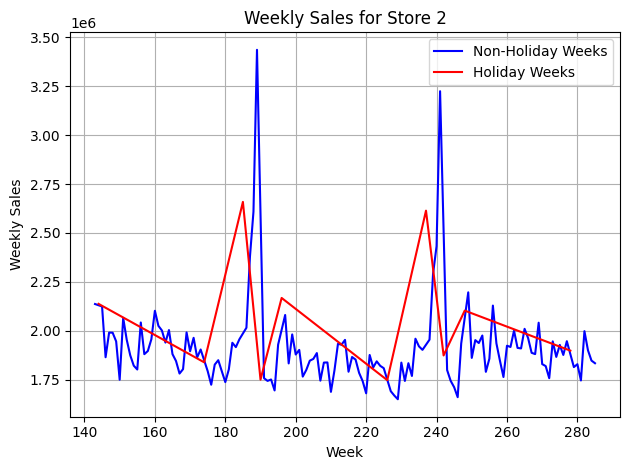

In [179]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_2.index, non_holiday_2['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_2.index, holiday_2['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 2')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()



In the second store, we notice that there is a significant difference in the total sales amount compared to store 1, which is much higher.

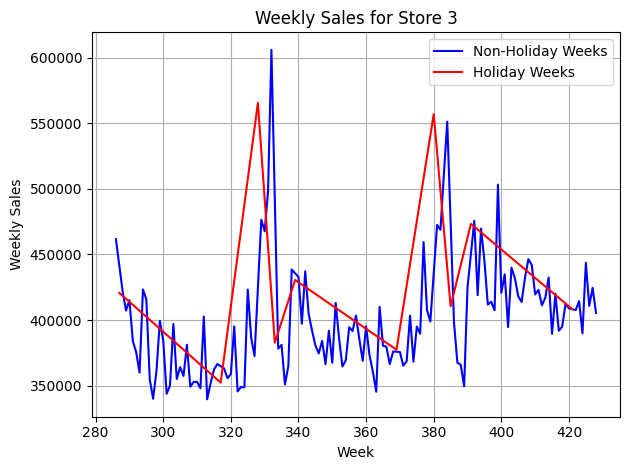

In [180]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_3.index, non_holiday_3['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_3.index, holiday_3['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 3')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 3 consistently reports among the lowest weekly sales figures compared to other stores. Despite occasional spikes during holidays, its sales performance falls significantly short of Stores 1 and 2, which achieve over 3 million and approximately 550k in total sales, respectively.

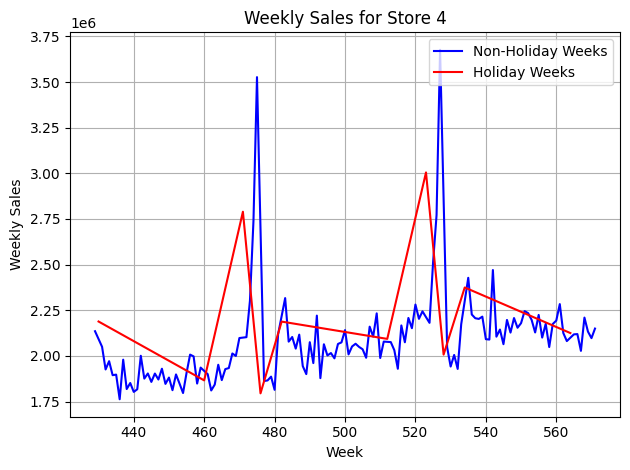

In [181]:
import matplotlib.pyplot as plt

# Store 4 with non-Holidays
non_holiday_4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with Holidays
holiday__4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 1)].iloc[:140]

plt.plot(non_holiday_4.index, non_holiday_4['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

plt.plot(holiday__4.index, holiday__4['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 4')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 4 demonstrates consistent sales performance akin to that of Store 1 and Store 2. This observation suggests that Stores 1, 2, and 4 likely cater to a comparable population size and exhibit similar consumer foot traffic patterns, in contrast to Store 3.


### Fuel Price

<Axes: >

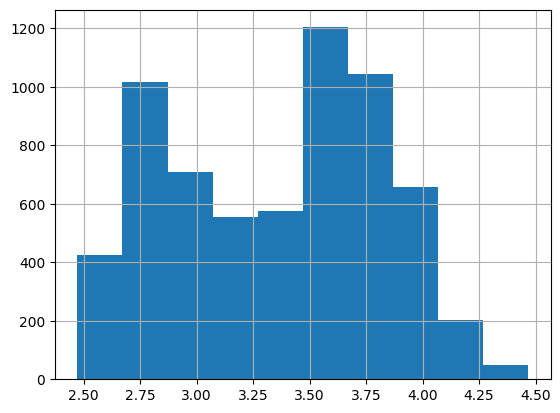

In [182]:
#view histogram for fuel price
df['Fuel_Price'].hist()

We have a bimodal distribution for our fuel prices 

In [183]:
#view summary statistics
mean = df['Fuel_Price'].mean()
stdDev = df['Fuel_Price'].std()


print(f"mean: {mean}")
print(f"Standard Devation: {stdDev}")


mean: 3.358606837606838
Standard Devation: 0.4590197071928525


### Consumer Price Index

<Axes: >

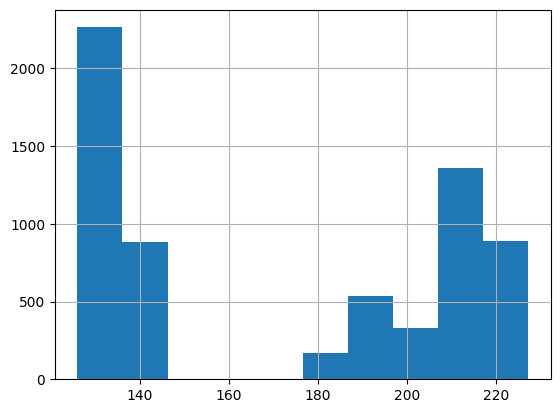

In [184]:
#view histogram
df['CPI'].hist()

it looks like we have a really weird discrete set of values. I wonder why there seems to be a chunk missing. From my understanding CPI is a continuous index that doesn't simply jump out like that. 

To dig deeper into why this occured let's look at CPI for each store (it should be roughly the same because the data is from the same time frame but it help determine the cause).  

<Axes: >

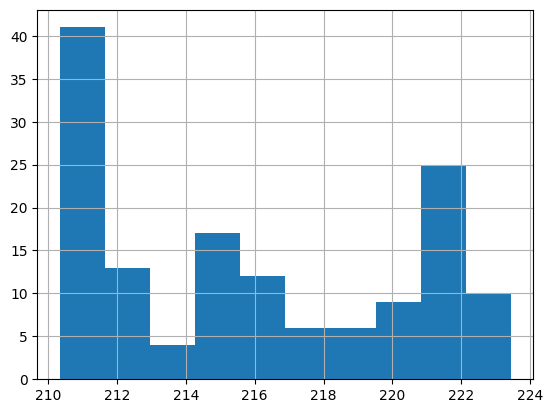

In [185]:
#histogram for store1
df[df['Store'] == 1]['CPI'].hist()

In [186]:
frame = df[df['Store'] == 1]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [210.3374261, 223.4442513]


It looks store 1 is continuous in the rough range [210, 223]

<Axes: >

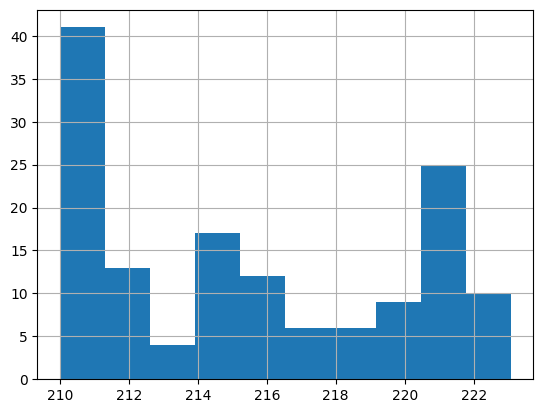

In [187]:
#view histogram of cpi for store 2
df[df['Store'] == 2]['CPI'].hist()


In [188]:
frame = df[df['Store'] == 2]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [209.9984585, 223.0783366]


Store 2's CPI values seem to be continuous in a very similar range as store 1

<Axes: >

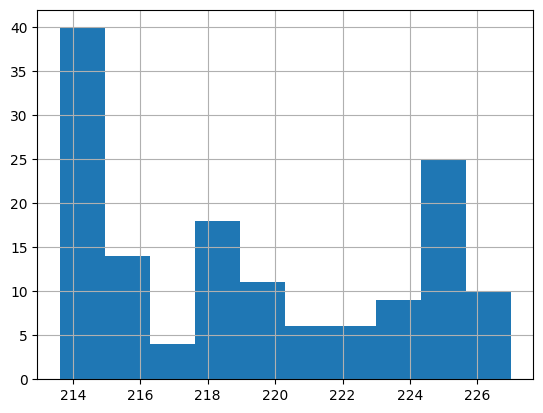

In [189]:
#view histogram of CPI's for store 3
df[df['Store'] == 3]['CPI'].hist()


In [190]:
frame = df[df['Store'] == 3]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [213.6196139, 226.9873637]


Again, very similar range of CPI values. So, stores 1, 2, and 3 all have similar CPI ranges and store 4 seems to be an outlier in the CPI data

<Axes: >

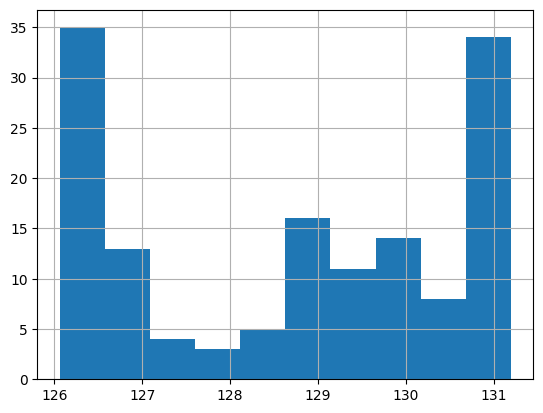

In [191]:
#view histogram of CPI values for store 4
df[df['Store'] == 4]['CPI'].hist()


In [192]:
frame = df[df['Store'] == 4]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [126.064, 131.1930968]


As suspected, store 4 is completely misasligned with the other stores in terms of it's CPI values. Hence, why we had that huge gap in data in the histogram of ALL CPI values. 

### Unemployment

<Axes: >

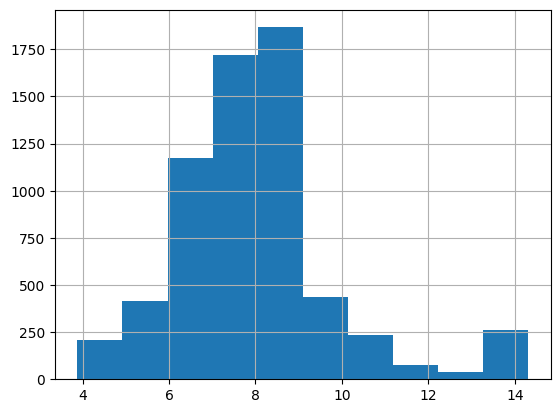

In [193]:
df['Unemployment'].hist()

## Feature vs Sales

### Tempature vs Sales

We want to use a hypothesis test to figure out whether temperature affects sales.

*Null Hypothesis*: The average temperature of the area has no effect on the sales.

*Alternative Hypothesis*: The average temperature of the area does have an effect on the sales.

Assume that we have a significance level of 0.05.

First, let's plot the stores, with their respective average temperature and weekly sales. We'll use a scatter plot, with each dot being a store from the set.

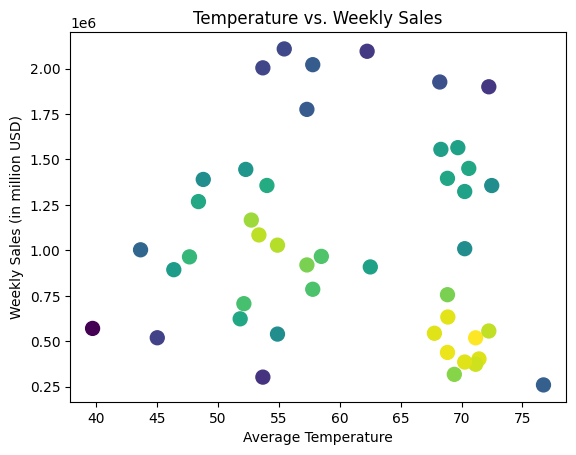

In [194]:
store_avgs = df.groupby("Store").mean("Temperature")

temp = store_avgs["Temperature"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Temperature vs. Weekly Sales")
plt.xlabel("Average Temperature")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

We can see that the stores are scattered around pretty evenly, with small clusters around the average temperature of 45-55 and 65-75 degree range.

Let's check the correlation between the two variables.

In [195]:
result = sci.stats.pearsonr(store_avgs["Temperature"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.07638774908646385, pvalue=0.6179663423198961)


Notice that the pearson correlation coefficient is -0.076, meaning that it is slightly negative. This means that as the average temperature increases, then the weekly sales decrease. Since the p value is larger than our alpha value (0.617), we fail to reject the null hypothesis. In other words, we can see that the average temperature does not have an effect on weekly sales.

### Fuel Price vs Sales

### CPI vs Sales

### Unemployment vs Sales

We want to now test if unemployment rates have an effect on the stores' average weekly sales.

*Null Hypothesis:* The unemployment rate has no effect on the stores' average weekly sales.

*Alternative Hypothesis:* The unemployment rate does have an effect on the stores' average weekly sales.

Assume that our significance level is 0.05.

We can graph a scatter plot of each store:

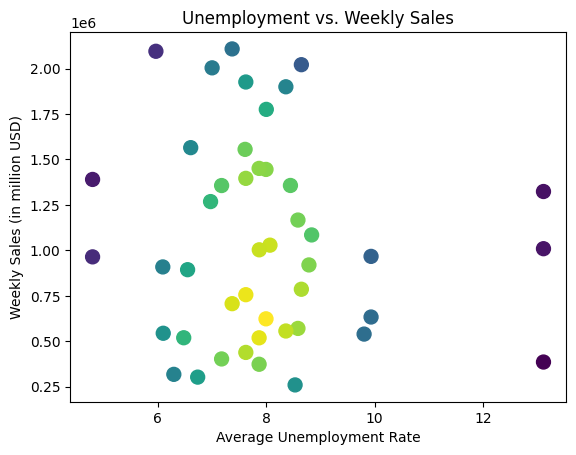

In [197]:
temp = store_avgs["Unemployment"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Unemployment vs. Weekly Sales")
plt.xlabel("Average Unemployment Rate")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

We can see that most of the stores' average unemployment rates are between 6-9 percent, with sales being scattered pretty evenly across the board.

Let's now check the correlation between the two variables:

In [198]:
result = sci.stats.pearsonr(store_avgs["Unemployment"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.11228079769921509, pvalue=0.4627451284572275)


Notice that the correlation coefficient is -0.112, which is slightly negative. This means that as unemployment rates go up, the weekly sales will go slighly down. Since our p value is 0.46, which is greater than 0.05, we fail to reject the null hypothesis. In other words, the unemployment rate does not have an effect on weekly sales.